# Library

In [1]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Python path
import sys
base_folder = 'DataScience'
location_base = os.path.join(os.getcwd().split(base_folder)[0], base_folder)
location_module = [os.path.join(location_base, 'Module')] 
for each in location_module:
    if each not in sys.path:
        sys.path.append(each)

# Auto reload of library
%reload_ext autoreload
%autoreload 2

from import_KK import *
from data_KK import *
DeviceStrategy_CPU()
from preprocessing_KK import *
from preprocessing_text_KK import * ##
from visualization_KK import * ##
from algorithm_textmining import *
from algorithm_machinelearning_KK import *
from algorithm_deeplearning_KK import *
from evaluation_KK import *

# 하이퍼파라미터
CATEGORY_BK = ['경제', '사회', '문화', '국제']
CATEGORY_CR = ['세계', '경제', '생활/문화', '오피니언', '사회', 'IT/과학']
IMAGE_LOCATION = os.path.join('.', 'Data', 'baby-icon_ver1.png')
COLNAME_CATEGORY = '일자'
COLNAME_MINING = '제목'
SAVE_LOCATION = r'C:\Users\user\Desktop\Data'    # inu
# SAVE_LOCATION = r'C:\Users\KK\Desktop\Data'    # home

JAVA is in the system path?:  False
JAVA is in the system path?:  Adding...


0it [00:00, ?it/s]
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


ModuleNotFoundError: No module named 'bertopic'

# Data Preprocessing

## BigKinds

In [ ]:
# 데이터로딩
df_news = get_data_from_path(os.path.join(os.getcwd(), 'Data', 'BigKinds'), folder_name=True)
# 전처리
## 중복 처리
df_news.drop_duplicates(subset=['뉴스 식별자', '언론사', COLNAME_MINING], inplace=True, ignore_index=True)
## 불필요 변수 삭제
colname_delete = ['뉴스 식별자', '기고자', '통합 분류2', '통합 분류3', '사건/사고 분류1', '사건/사고 분류2', '사건/사고 분류3',
                  '키워드', '특성추출(가중치순 상위 50개)', 'URL', '분석제외 여부']
df_news = df_news[[col for col in df_news.columns if col not in colname_delete]]
## 카테고리 필터
category_filter = [each for each in df_news['통합 분류1'].unique() if each.split('>')[0] in CATEGORY_BK]
print(category_filter)
df_news = df_news[df_news['통합 분류1'].apply(lambda x: x in category_filter)].reset_index().iloc[:,1:]
df_news['Category'] = df_news['통합 분류1'].apply(lambda x: x.split('>')[0])
## 전처리
df_news[COLNAME_MINING] = df_news[COLNAME_MINING].progress_apply(lambda x: text_preprocessor(x, del_number=False, del_bracket_content=False))
## 결측치 및 빈문자 제거
df_news = df_news[~df_news[COLNAME_MINING].isnull()].reset_index().iloc[:,1:].copy()
df_news = df_news[df_news[COLNAME_MINING].str.len() != 0].reset_index().iloc[:,1:]

# 날짜 변환
## 연도 반영
df_news[COLNAME_CATEGORY+'_Year'] = pd.to_datetime(df_news[COLNAME_CATEGORY].astype(str)).dt.year
## 연도+월 반영
df_news[COLNAME_CATEGORY+'_YearMonth'] = pd.to_datetime(df_news[COLNAME_CATEGORY].astype(str)).dt.strftime('%Y-%m')
## 연도그룹 반영
df_news[COLNAME_CATEGORY+'_Era'] = df_news[COLNAME_CATEGORY].apply(lambda x: '2013 ~ 2017' if str(x)[:4] in ['2013', '2014', '2015', '2016', '2017']
                                                                                            else '2018 ~ 2023')

# 긍부정 라벨 추가
df_news_sentiment = get_data_from_path(os.path.join(os.getcwd(), 'Data', 'Sentiment'), folder_name=False)
df_news_sentiment = df_news_sentiment.sort_values(by='Unnamed: 0').reset_index().iloc[:,2:]
df_news_sentiment.columns = ['Sentiment']
df_news_sentiment['Sentiment'] = df_news_sentiment.Sentiment.apply(lambda x: 'Positive' if x==2 else 'Negative')
df_news_sentiment['Positive'] = df_news_sentiment.Sentiment.apply(lambda x: 1 if x=='Positive' else 0)
df_news_sentiment['Negative'] = df_news_sentiment.Sentiment.apply(lambda x: -1 if x=='Negative' else 0)
df_news = pd.concat([df_news, df_news_sentiment], axis=1)
## 최대 중복 처리
df_news.drop_duplicates(subset=['언론사', COLNAME_MINING], inplace=True, ignore_index=True)
df_news.drop_duplicates(subset=[COLNAME_MINING], inplace=True, ignore_index=True)

# 저장
df_news.to_csv(os.path.join(SAVE_LOCATION, 'df_news_bigkinds.csv'), index=False, encoding='utf-8-sig')

In [ ]:
## 불러오기
df_news_bk = pd.read_csv(os.path.join(SAVE_LOCATION, 'df_news_bigkinds.csv'))
print('Category: ', df_news_bk['통합 분류1'].value_counts())
print('Category: ', df_news_bk.Category.value_counts())

## Naver Crawling

In [ ]:
# # 데이터로딩
# df_news = get_data_from_path(os.path.join(os.getcwd(), 'Data', 'NaverNews'), folder_name=True)

# # 필터링
# ## 중복 처리
# df_news.drop_duplicates(subset=['Press', 'Title'], inplace=True, ignore_index=True)
# ## 불필요 변수 삭제
# colname_delete = ['Content', 'URL_Origin']
# df_news = df_news[[col for col in df_news.columns if col not in colname_delete]]
# ## 카테고리 필터
# category_filter = [each for each in df_news.Category.unique() if each in CATEGORY_CR]
# df_news = df_news[df_news.Category.apply(lambda x: x in category_filter)].reset_index().iloc[:,1:]
# ## 언론사 중복 필터
# df_news.Press = df_news.Press.progress_apply(lambda x: str(x).split('언론사 선정')[0])

# # 날짜 변환
# df_news.Date = pd.to_datetime(df_news.Date)
# ## 연도 반영
# df_news['Date_Year'] = pd.to_datetime(df_news.Date.astype(str)).dt.year
# ## 연도+월 반영
# df_news['Date_YearMonth'] = pd.to_datetime(df_news.Date.astype(str)).dt.strftime('%Y-%m')
# ## 연도그룹 반영
# df_news['Date_Period'] = df_news.Date_Year.apply(lambda x: '2013 ~ 2017' if str(x)[:4] in ['2013', '2014', '2015', '2016', '2017']
#                                                                           else '2018 ~ 2023')
# df_news = df_news[['Folder_Name', 'Date', 'Date_Year', 'Date_YearMonth', 'Date_Period', 'Press', 'Category', 'Title', 'Comment', 'URL_Naver']]

# # 전처리
# df_news['Title'] = df_news['Title'].progress_apply(lambda x: text_preprocessor(x, del_number=False, 
#                                                                                del_bracket_content=False))
# df_news = df_news[~df_news['Title'].isnull()].reset_index().iloc[:,1:].copy()
# df_news = df_news[df_news['Title'].str.len() != 0].reset_index().iloc[:,1:]
# ## 댓글 길이가 5이상 & 갯수가 5개 이상 필터
# df_news['Comment'] = df_news['Comment'].progress_apply(lambda x: [i for i in literal_eval(x) if len(i) >= 5])
# df_news = df_news[df_news['Comment'].progress_apply(lambda x: len(x) >= 5)]

# # 언론사 필터
# ## 댓글 평균이 5이상 필터 & 발행기사수 Top100 필터
# df_news['Comment_Len'] = df_news.Comment.apply(lambda x: len(x))
# df_temp = df_news.groupby('Press')['Comment_Len'].mean()
# del_press = list(pd.DataFrame(df_temp[df_temp < 5]).index)
# del_press = del_press + list(dict(df_news.Press.value_counts()).keys())[100:]
# df_news = df_news[~df_news.Press.isin(del_press)].reset_index().iloc[:,1:]
# df_news = df_news.drop('Comment_Len', axis=1)

# # 댓글기준 explode
# df_news_explode = df_news.copy()
# df_news_explode = df_news_explode.explode('Comment')

# # 저장
# df_news.to_csv(os.path.join(SAVE_LOCATION, 'df_news_crawling.csv'), index=False, encoding='utf-8-sig')
# df_news_explode.to_csv(os.path.join(SAVE_LOCATION, 'df_news_explode_crawling.csv'), index=False, encoding='utf-8-sig')

In [ ]:
## 불러오기
df_news_nv = pd.read_csv(os.path.join(SAVE_LOCATION, 'df_news_crawling.csv'))
print('Category: ', df_news_nv.Category.value_counts())
df_newse_nv = pd.read_csv(os.path.join(SAVE_LOCATION, 'df_news_explode_crawling.csv'))

## Word Frequency

- **데이터:** 구글 뉴스 + 네이버 뉴스
- **카테고리:** 경세 + 사회 + 문화 + 국제

In [ ]:
# # 연도데이터 기준 전처리
# wf_soy, waf_soy, wf_tf, waf_tf = preprocessing_wordfreq(df_news, colname_target=COLNAME_MINING, colname_category=COLNAME_CATEGORY+'_Year', 
#                          save_local=True)

# # 연도그룹데이터 기준 전처리
# wf_era_soy, waf_era_soy, wf_era_tf, waf_era_tf = preprocessing_wordfreq(df_news, colname_target=COLNAME_MINING, colname_category=COLNAME_CATEGORY+'_Era', 
#                          save_local=True,
#                          save_name_list=['word_freq_soynlp_era.csv', 'wordadj_freq_soynlp_era.csv', 
#                                          'word_freq_tfidf_era.csv', 'wordadj_freq_tfidf_era.csv'])
# ## 안되면 아래줄 실행
# if wf_era_tf.shape[0] == 0:
#     wf_era_tf = wf_tf.copy()
#     wf_era_tf.category.apply(lambda x: '2013 ~ 2017' if x in ['2013', '2014', '2015', '2016', '2017']
#                                                       else '2018 ~ 2023')
#     wf_era_tf = wf_era_tf.groupby(list(wf_era_tf.columns[:2])).mean().reset_index()
#     waf_era_tf = pd.DataFrame()
#     for category in tqdm(sorted(df_news[COLNAME_CATEGORY+'_Era'].unique())):
#         df_sub = df_news[df_news[COLNAME_CATEGORY+'_Era'] == category]
#         waf_era = preprocessing_adjwordcount(wf_era_tf[['word']], df_sub[COLNAME_MINING], num_showkeyword=5)
#         waf_era['category'] = str(category)
#         waf_era = waf_era[['category']+list(waf_era.columns[:-1])]
#         waf_era_tf = pd.concat([waf_era_tf, waf_era], axis=0, ignore_index=True)
#     save_name = os.path.join(os.getcwd(), 'Data', 'word_freq_tfidf_era.csv')
#     wf_era_tf.to_csv(save_name, index=False, encoding='utf-8-sig')
#     save_name = os.path.join(os.getcwd(), 'Data', 'wordadj_freq_tfidf_era.csv')
#     waf_era_tf.to_csv(save_name, index=False, encoding='utf-8-sig')
# ######################

# # 연도감성데이터 기준 전처리
# wf_senti_soy, waf_senti_soy, wf_senti_tf, waf_senti_tf = preprocessing_wordfreq(df_news, colname_target=COLNAME_MINING, colname_category='Sentiment', 
#                          num_showkeyword=10,
#                          save_local=True, 
#                          save_name_list=['word_freq_soynlp_senti.csv', 'wordadj_freq_soynlp_senti.csv', 
#                                          'word_freq_tfidf_senti.csv', 'wordadj_freq_tfidf_senti.csv'])

In [ ]:
# 불러오기
save_name_list=['word_freq_soynlp.csv', 'wordadj_freq_soynlp.csv', 
                'word_freq_tfidf.csv', 'wordadj_freq_tfidf.csv']
save_name = os.path.join(os.getcwd(), 'Data', save_name_list[0])
wf_soynlp = pd.read_csv(save_name)
save_name = os.path.join(os.getcwd(), 'Data', save_name_list[1])
waf_soynlp = pd.read_csv(save_name)
save_name = os.path.join(os.getcwd(), 'Data', save_name_list[2])
wf_tfidf = pd.read_csv(save_name)
save_name = os.path.join(os.getcwd(), 'Data', save_name_list[3])
waf_tfidf = pd.read_csv(save_name)

# 불러오기
save_name_list=['word_freq_soynlp_era.csv', 'wordadj_freq_soynlp_era.csv', 
                'word_freq_tfidf_era.csv', 'wordadj_freq_tfidf_era.csv']
save_name = os.path.join(os.getcwd(), 'Data', save_name_list[0])
wf_era_soynlp = pd.read_csv(save_name)
save_name = os.path.join(os.getcwd(), 'Data', save_name_list[1])
waf_era_soynlp = pd.read_csv(save_name)
save_name = os.path.join(os.getcwd(), 'Data', save_name_list[2])
wf_era_tfidf = pd.read_csv(save_name)
save_name = os.path.join(os.getcwd(), 'Data', save_name_list[3])
waf_era_tfidf = pd.read_csv(save_name)

# 불러오기
save_name_list=['word_freq_soynlp_senti.csv', 'wordadj_freq_soynlp_senti.csv', 
                'word_freq_tfidf_senti.csv', 'wordadj_freq_tfidf_senti.csv']
save_name = os.path.join(os.getcwd(), 'Data', save_name_list[0])
wf_senti_soynlp = pd.read_csv(save_name)
save_name = os.path.join(os.getcwd(), 'Data', save_name_list[1])
waf_senti_soynlp = pd.read_csv(save_name)
# save_name = os.path.join(os.getcwd(), 'Data', save_name_list[2])
# wf_posi_tfidf = pd.read_csv(save_name)
# save_name = os.path.join(os.getcwd(), 'Data', save_name_list[3])
# waf_posi_tfidf = pd.read_csv(save_name)

## Word Correlation

In [ ]:
# wf_corr_soynlp = preprocessing_wordfreq_to_corr(wf_soynlp, df_news, 
#                                                 colname_target=COLNAME_MINING, 
#                                                 colname_category=COLNAME_CATEGORY, 
#                                                 num_showkeyword=100, save_name='word_corrpair_soynlp.csv')
# G, centrality = plot_networkx(wf_soynlp, wf_corr_soynlp, 
#                               filter_criteria=0, plot=True, node_size='pagerank', 
#                               save_local=True, save_name='trend_year_networkx'+'.png')


In [ ]:
# # 관련성 전처리
# wf_corr_soynlp = preprocessing_wordfreq_to_corr(wf_era_soynlp, df_news, colname_target=COLNAME_MINING, colname_category=COLNAME_CATEGORY+'_Era', num_showkeyword=100, save_name='word_corrpair_soynlp_era.csv')
# waf_corr_soynlp = preprocessing_wordfreq_to_corr(waf_era_soynlp, df_news, colname_target=COLNAME_MINING, colname_category=COLNAME_CATEGORY+'_Era', num_showkeyword=100, save_name='wordadj_corrpair_soynlp_era.csv')
# wf_corr_tfidf = preprocessing_wordfreq_to_corr(wf_era_tfidf, df_news, colname_target=COLNAME_MINING, colname_category=COLNAME_CATEGORY+'_Era', num_showkeyword=100, save_name='word_corrpair_tfidf_era.csv')
# waf_corr_tfidf = preprocessing_wordfreq_to_corr(waf_era_tfidf, df_news, colname_target=COLNAME_MINING, colname_category=COLNAME_CATEGORY+'_Era', num_showkeyword=100, save_name='wordadj_corrpair_tfidf_era.csv')

# wf_senti_corr_soynlp = preprocessing_wordfreq_to_corr(wf_senti_soynlp, df_news, colname_target=COLNAME_MINING, colname_category='Sentiment', num_showkeyword=100, save_name='word_corrpair_soynlp_senti.csv')
# waf_senti_corr_soynlp = preprocessing_wordfreq_to_corr(waf_senti_soynlp, df_news, colname_target=COLNAME_MINING, colname_category='Sentiment', num_showkeyword=100, save_name='wordadj_corrpair_soynlp_senti.csv')
# # wf_senti_corr_tfidf = preprocessing_wordfreq_to_corr(wf_senti_tfidf, df_news, colname_target=COLNAME_MINING, colname_category='Sentiment', num_showkeyword=100, save_name='word_corrpair_tfidf_senti.csv')
# # waf_senti_corr_tfidf = preprocessing_wordfreq_to_corr(waf_senti_tfidf, df_news, colname_target=COLNAME_MINING, colname_category='Sentiment', num_showkeyword=100, save_name='wordadj_corrpair_tfidf_senti.csv')


In [ ]:
# 불러오기
save_name_list=['word_corrpair_soynlp_era.csv', 'wordadj_corrpair_soynlp_era.csv', 
                'word_corrpair_tfidf_era.csv', 'wordadj_corrpair_tfidf_era.csv']
save_name = os.path.join(os.getcwd(), 'Data', save_name_list[0])
wf_corr_soynlp = pd.read_csv(save_name)
save_name = os.path.join(os.getcwd(), 'Data', save_name_list[1])
waf_corr_soynlp = pd.read_csv(save_name)
save_name = os.path.join(os.getcwd(), 'Data', save_name_list[2])
wf_corr_tfidf = pd.read_csv(save_name)
save_name = os.path.join(os.getcwd(), 'Data', save_name_list[3])
waf_corr_tfidf = pd.read_csv(save_name)

save_name_list=['word_corrpair_soynlp_senti.csv', 'wordadj_corrpair_soynlp_senti.csv', 
                'word_corrpair_tfidf_senti.csv', 'wordadj_corrpair_tfidf_senti.csv']
save_name = os.path.join(os.getcwd(), 'Data', save_name_list[0])
wf_senti_corr_soynlp = pd.read_csv(save_name)
save_name = os.path.join(os.getcwd(), 'Data', save_name_list[1])
waf_senti_corr_soynlp = pd.read_csv(save_name)
# save_name = os.path.join(os.getcwd(), 'Data', save_name_list[2])
# wf_senti_corr_tfidf = pd.read_csv(save_name)
# save_name = os.path.join(os.getcwd(), 'Data', save_name_list[3])
# waf_senti_corr_tfidf = pd.read_csv(save_name)

# 연구문제0

## Korea Trend by Keywords

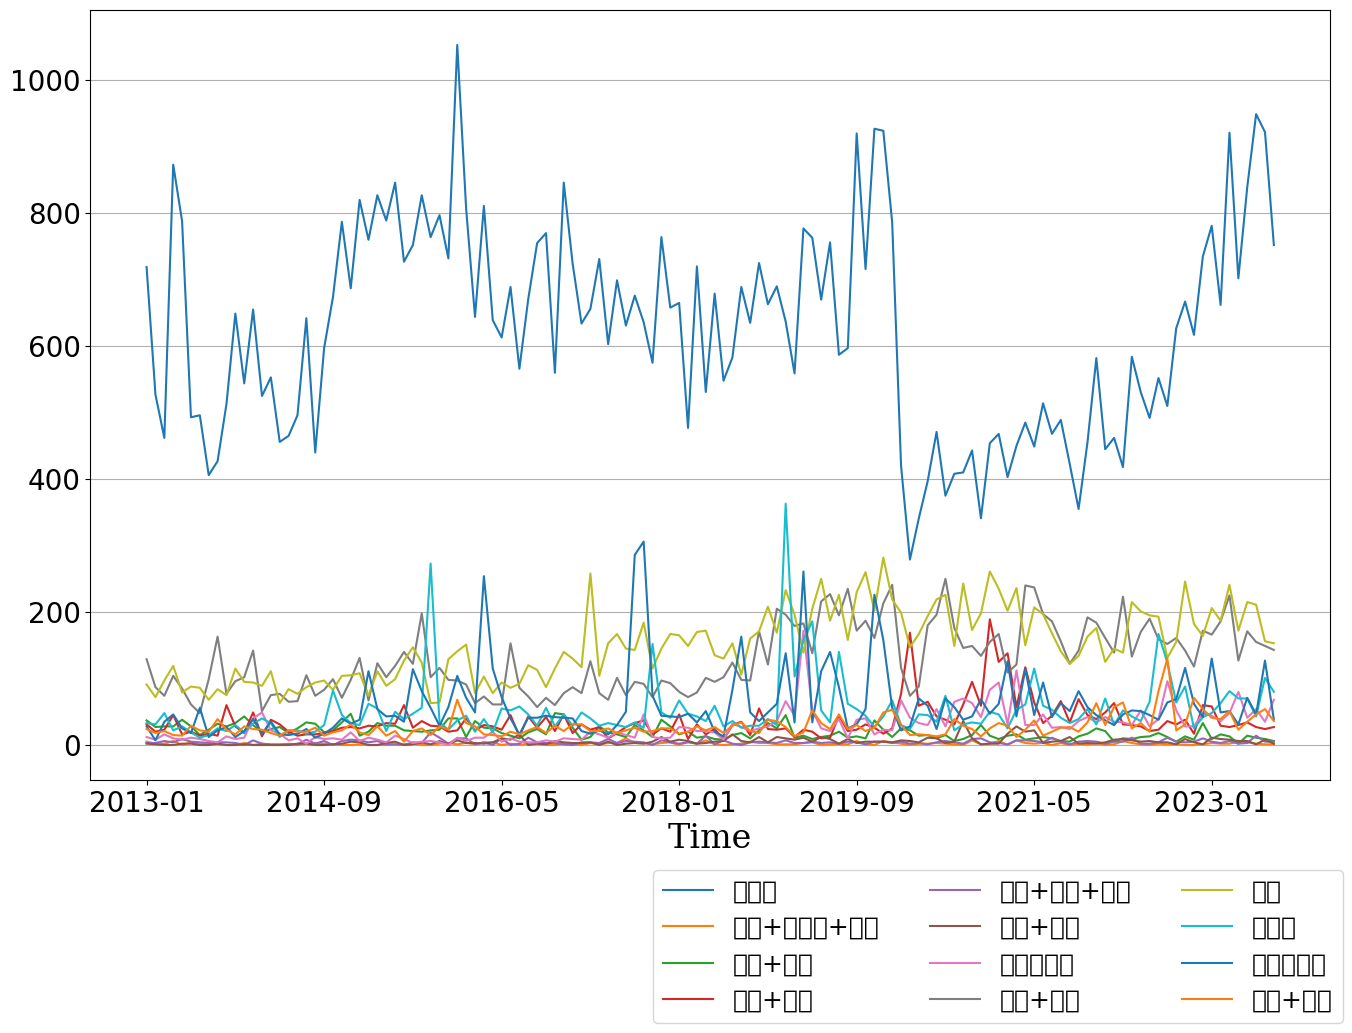

Numerical Scaling... ( 2023-10-28 22:15:06.000666 )


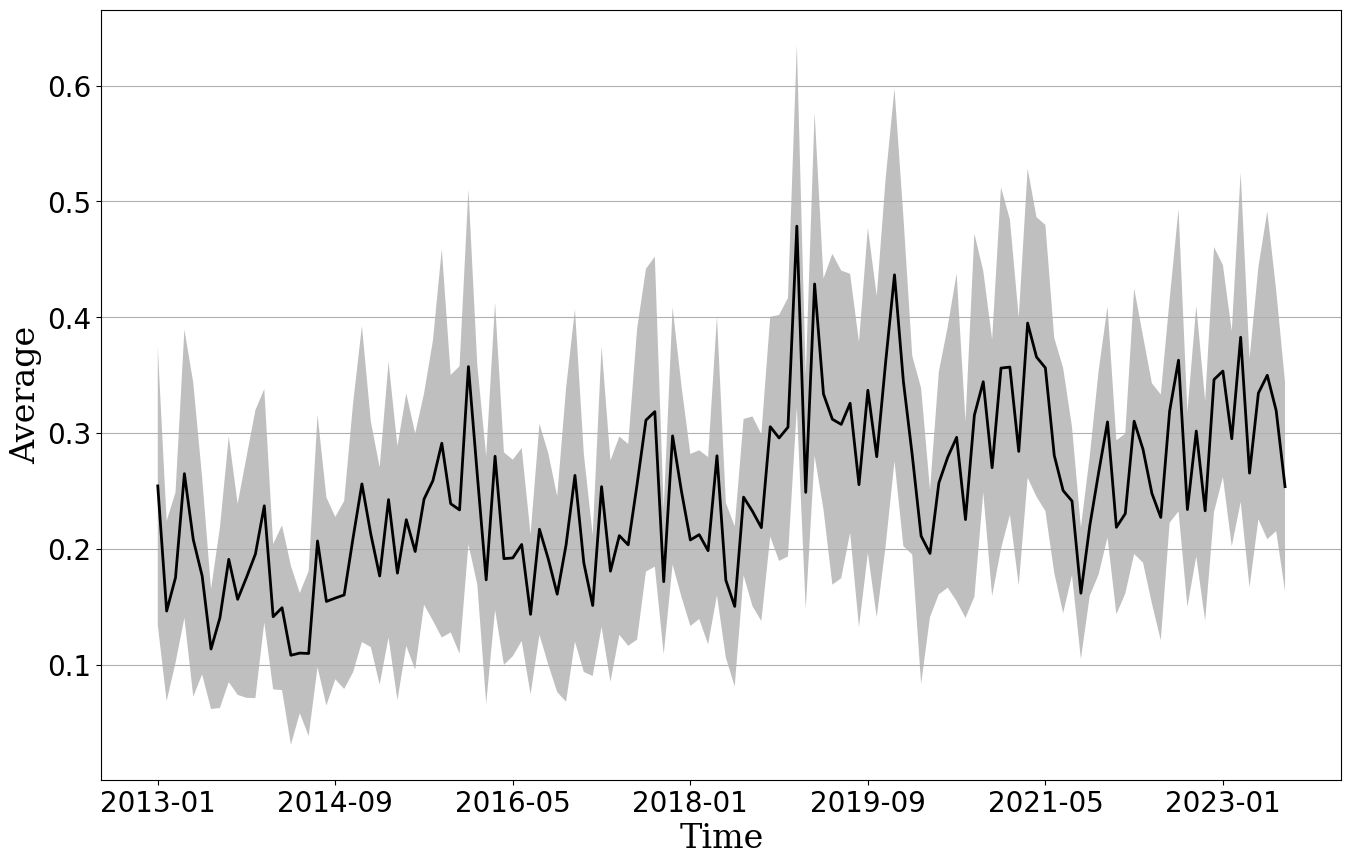

<<< Time Plot Summary >>>


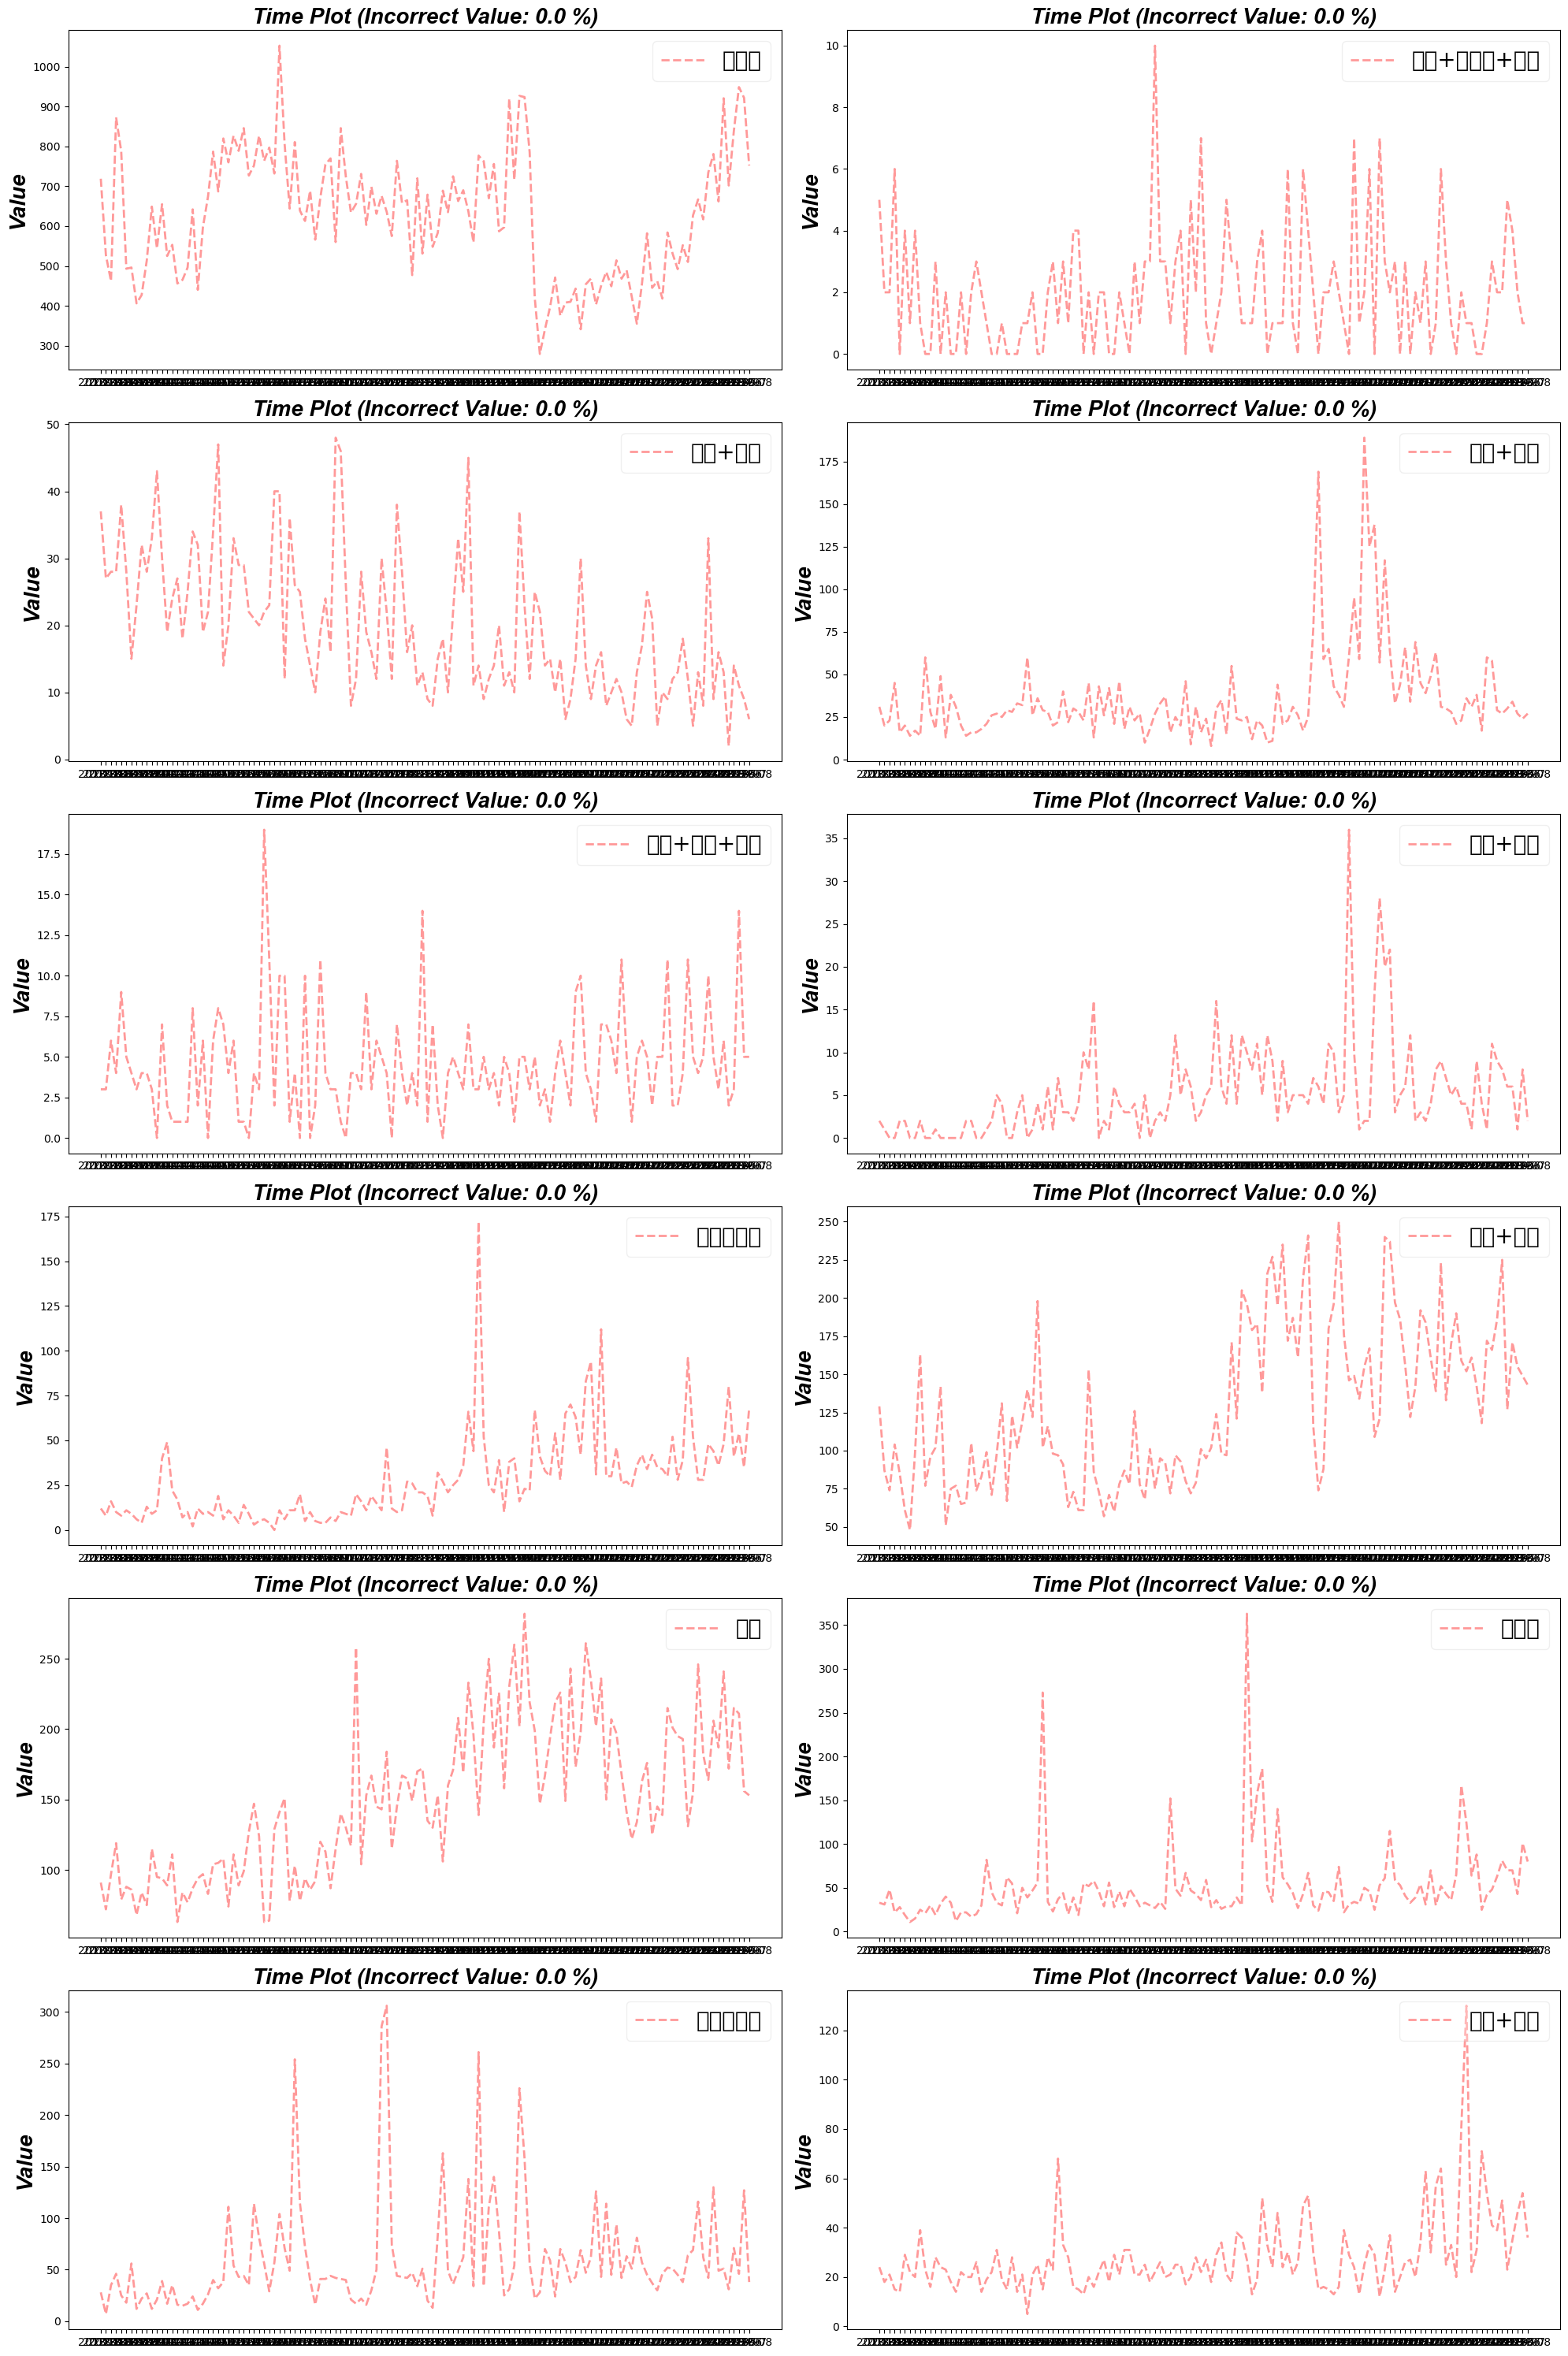

In [13]:
## 증가변수 필터
df_news_rising = df_news_bk.groupby(['Folder_Name', '일자_YearMonth'])['제목'].count().unstack(level=0).fillna(0)
RISING_CATEG = ['고령화', '노인+경제적+자립', '노인+봉사', '노인+의료', 
                '노인+주택+문제', '노인+혐오', '돌봄서비스', '세대+갈등', '소회', 
                '안락사', '알츠하이머', '연령+통합']
df_news_rising = df_news_rising[RISING_CATEG].copy()
## 시각화
plot_timeseries_dforigin(df_news_rising, save_local=True, save_name_initial='gt_total_origin.png')
plot_timeseries_dfmeanstd(df_news_rising, scaled=True, save_local=True, save_name_initial='gt_total_scaled.png')
plot_timeseries(df_news_rising, save_local=True, save_name_initial='gt_each_origin.png')

# 연구문제1

## 검색어 트랜드: 연도별

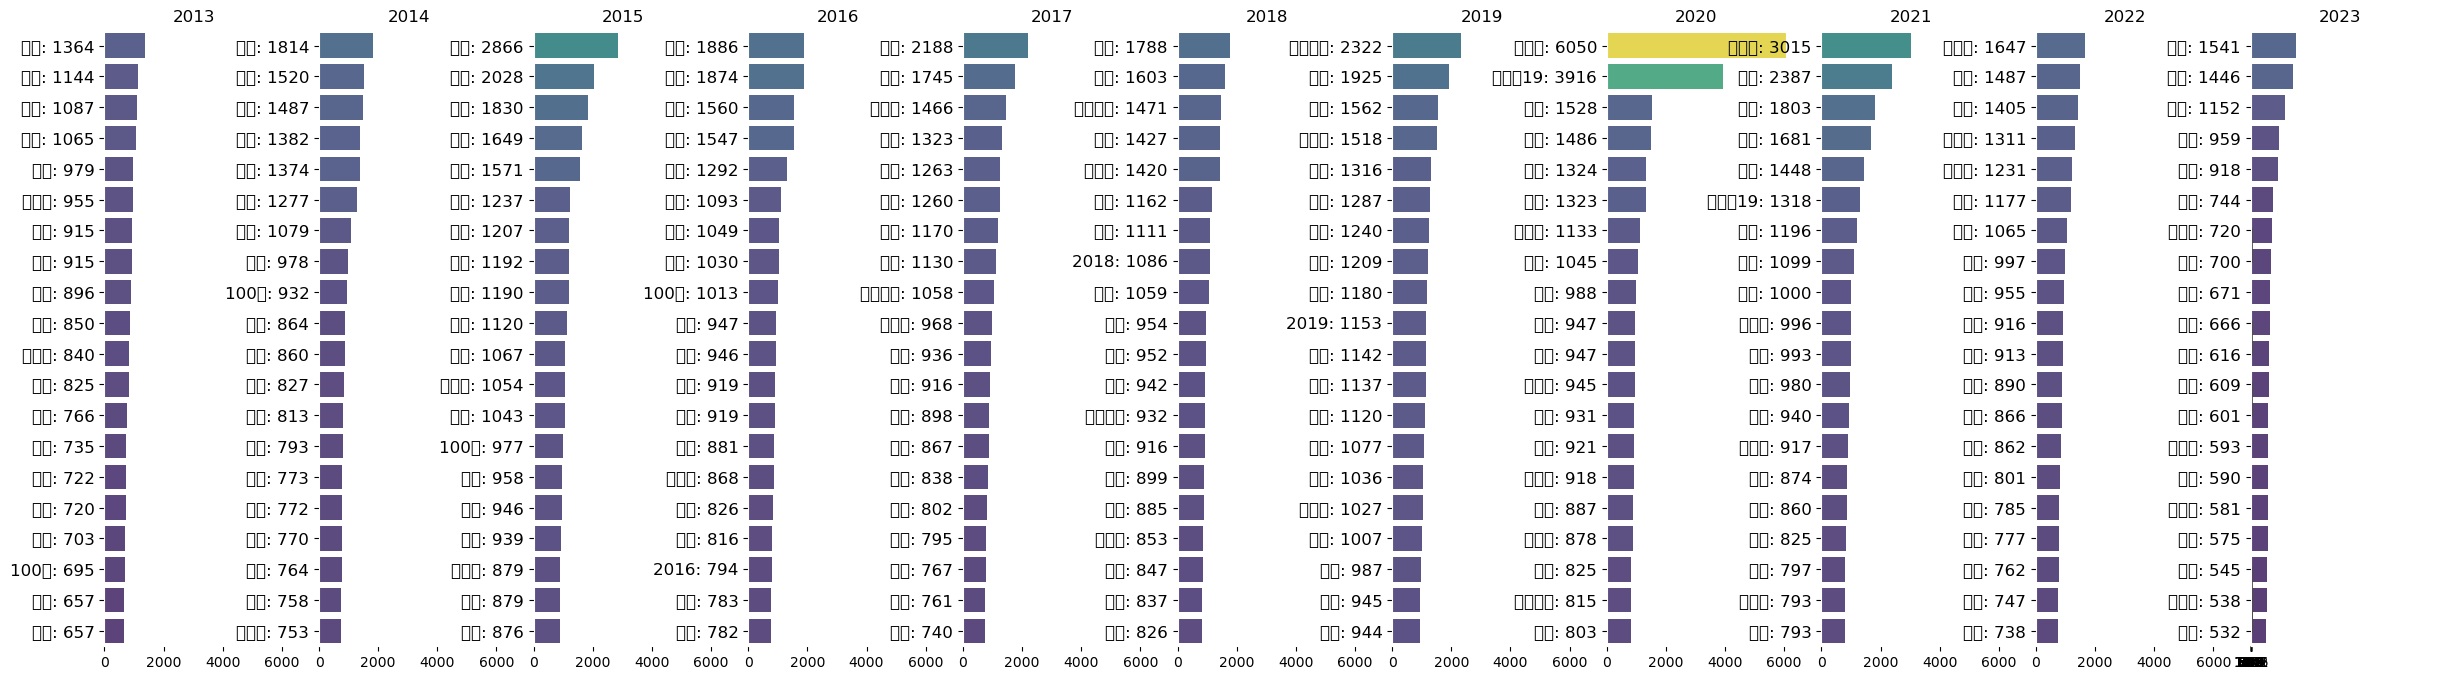

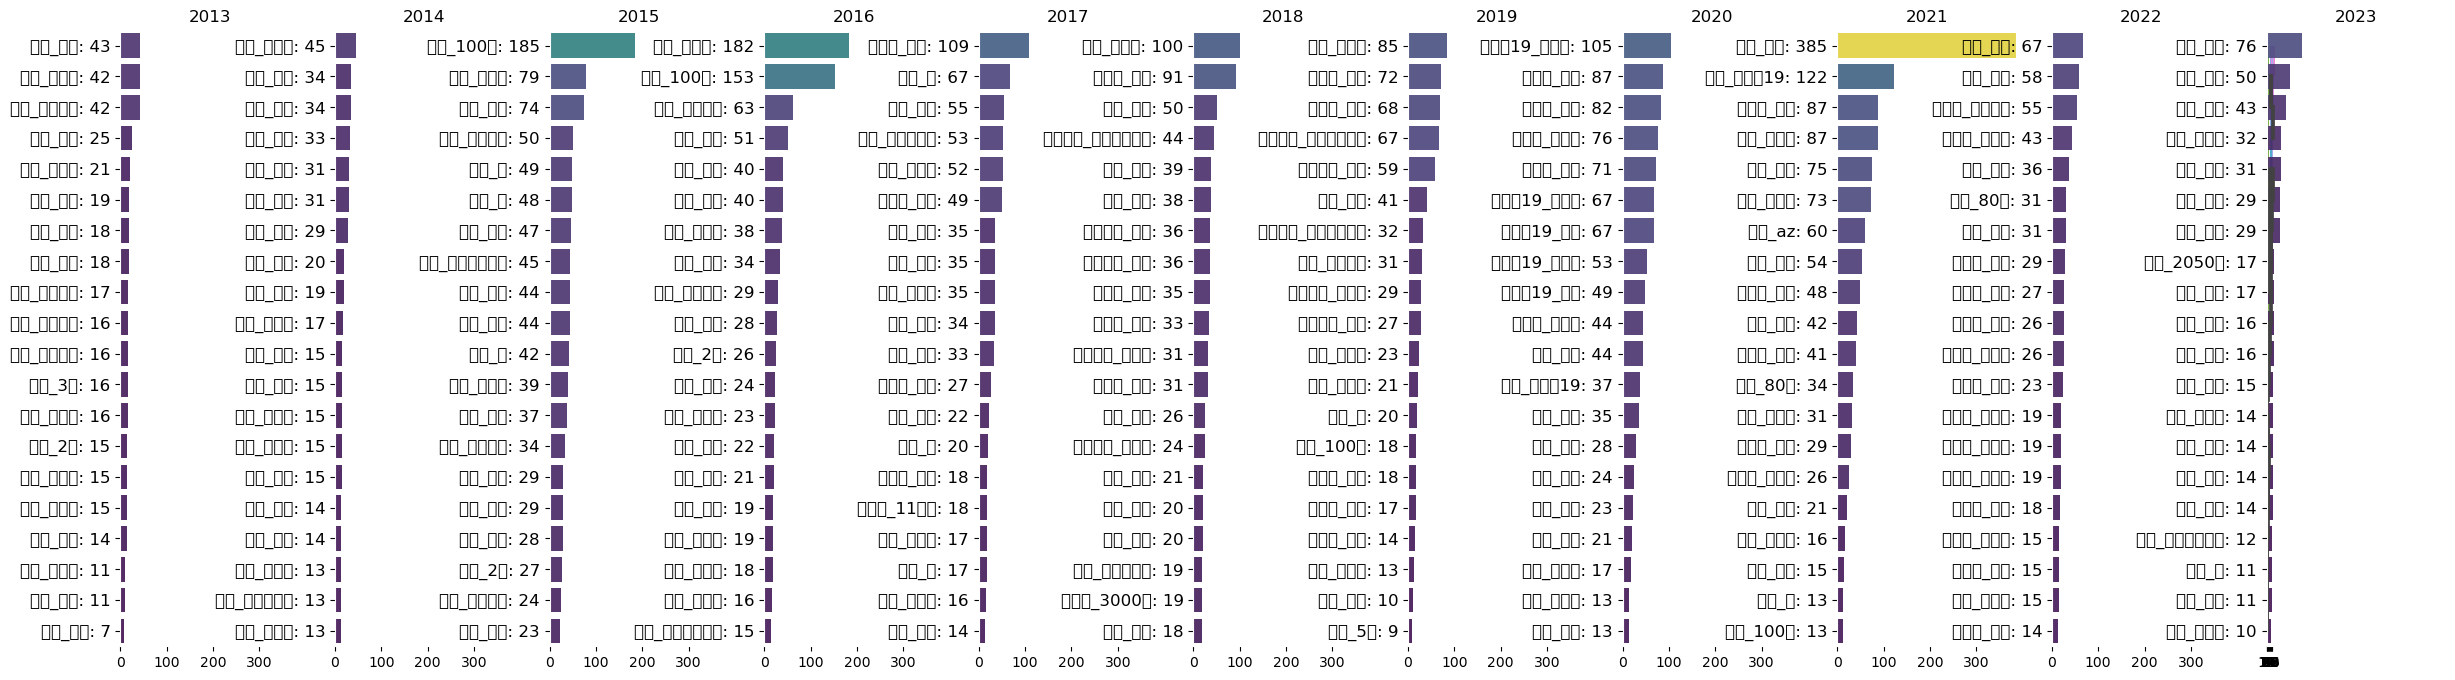

In [14]:
# word freq 비교 트랜드 시각화
plot_treemap_wordfreq(wf_soynlp, num_showkeyword=100, title='Ageism by Year', plot_studio=True, save_local=True, save_name='trend_year_compare_treemap.html')
plot_sunburst_wordfreq(waf_soynlp, title='Ageism by Year', plot_studio=True, save_local=True, save_name='trend_year_compare_sunburst.html')
plot_bar_wordfreq(wf_soynlp, figsize=(30,8), num_showkeyword=20, title='Ageism by Year', save_local=True, save_name='trend_year_compare_bar_byword.png')
plot_bar_wordfreq(waf_soynlp, figsize=(30,8), num_showkeyword=20, title='Ageism by Year', save_local=True, save_name='trend_year_compare_bar_bywordadj.png')

## 검색어 트랜드: 시대별

2013 ~ 2017


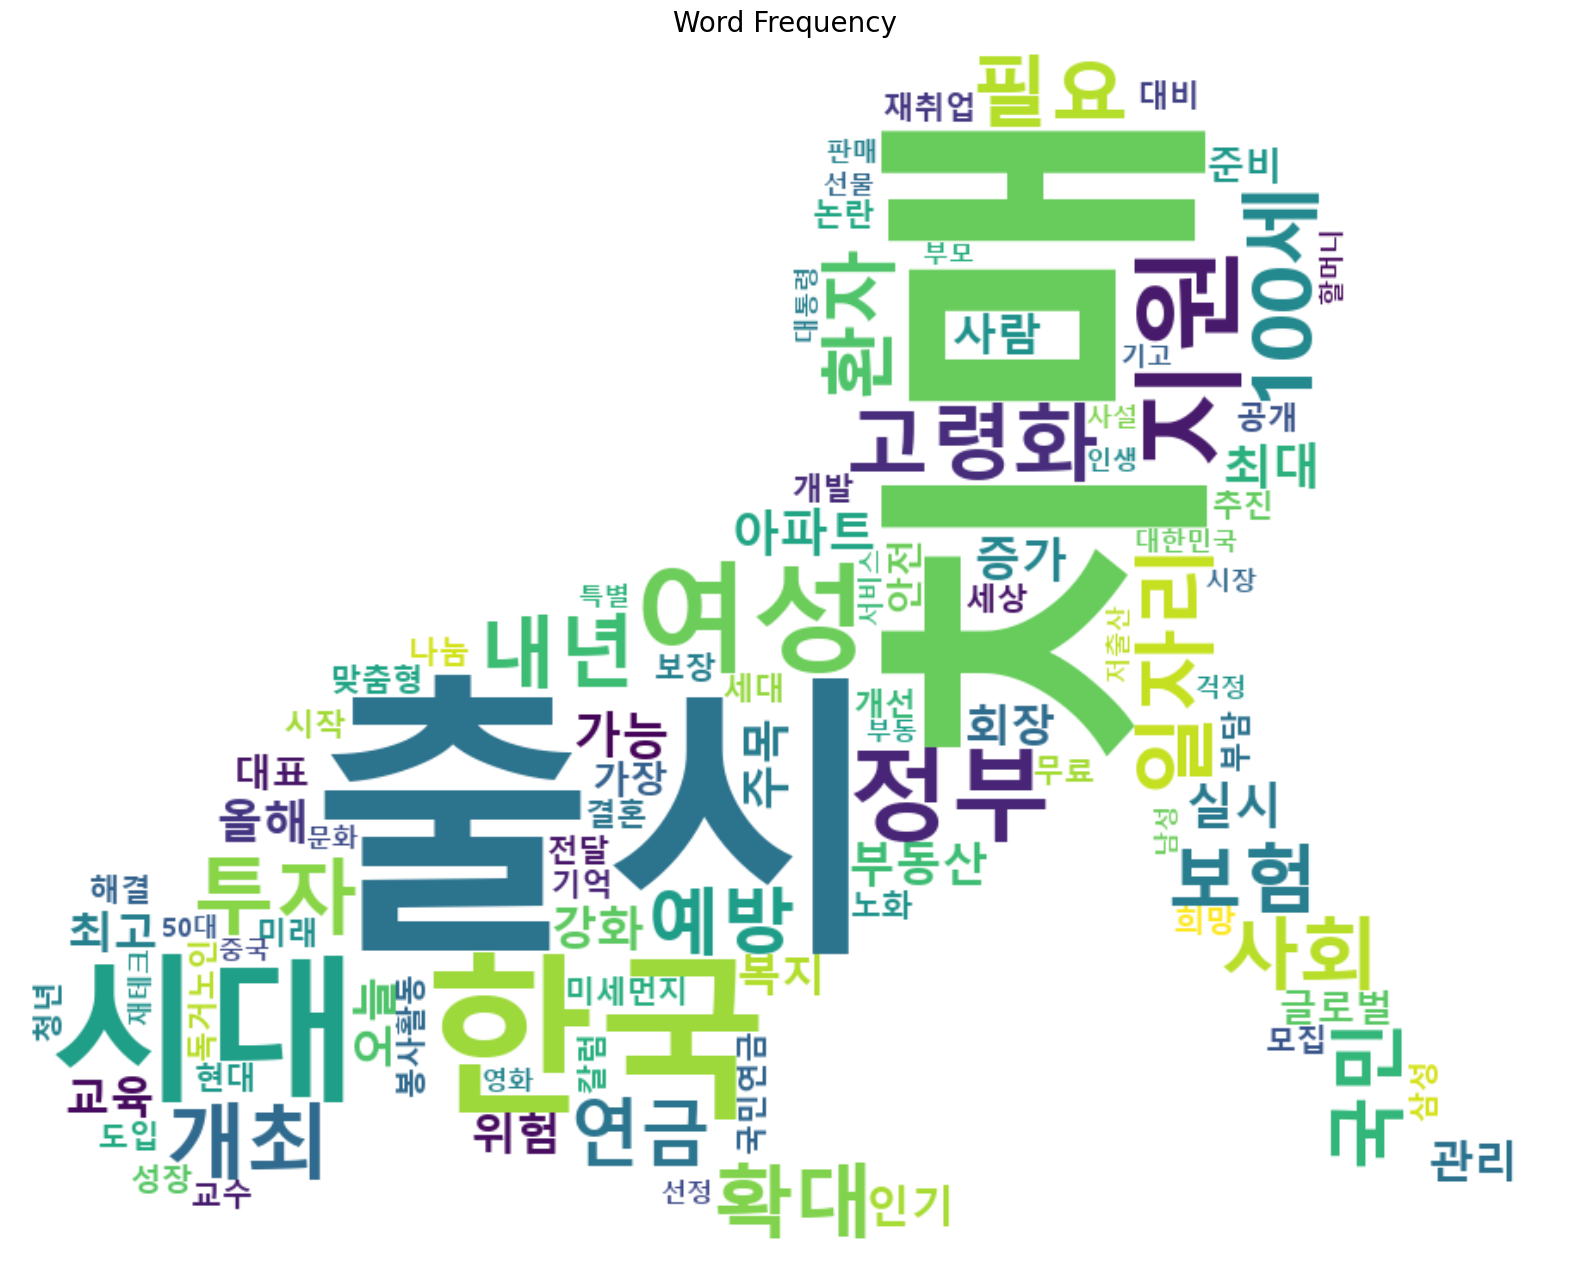

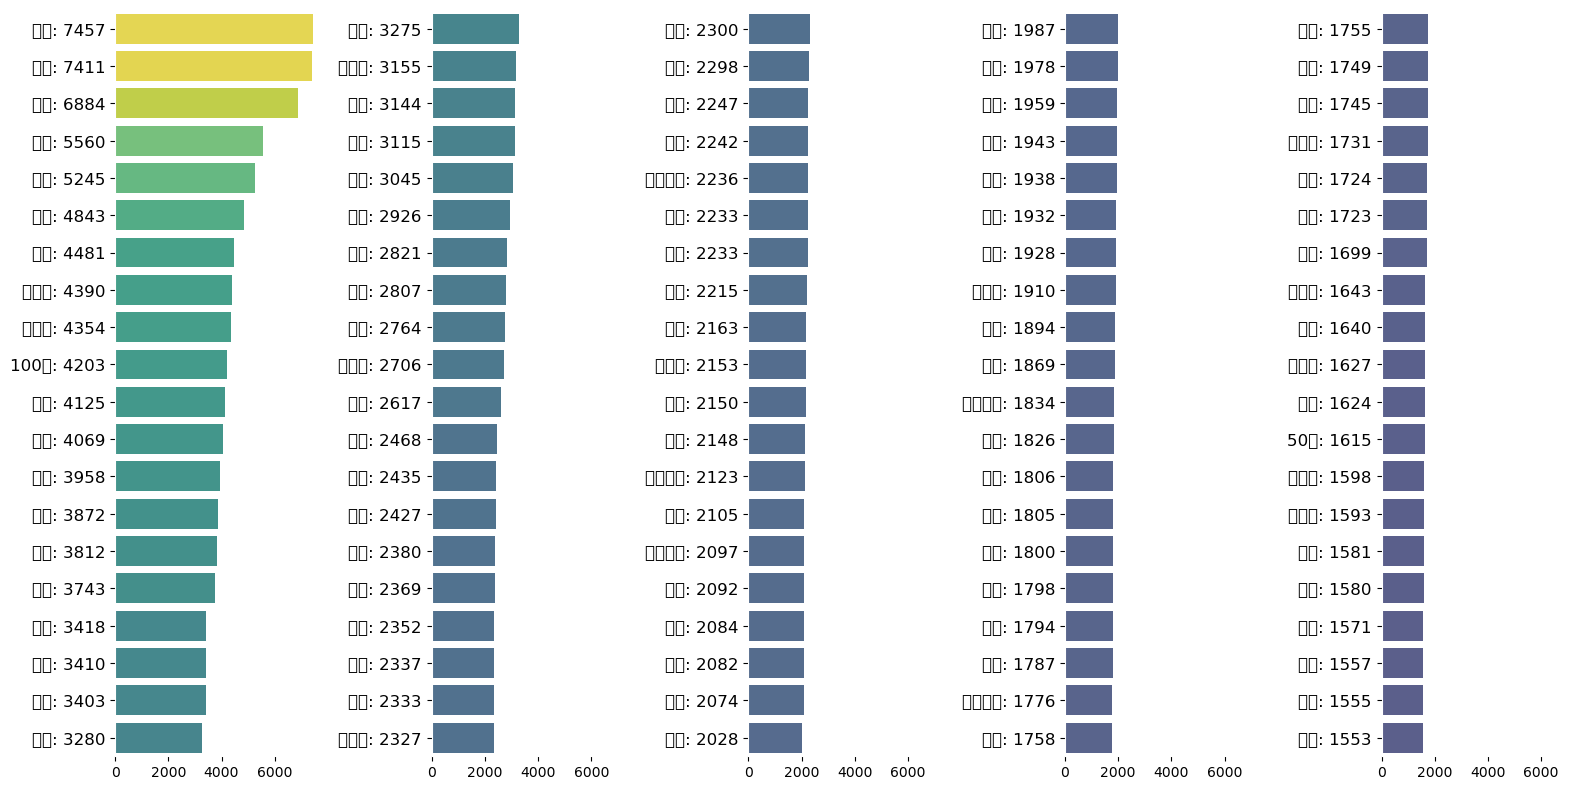

'Descriptive statistics of pairweight: '

count   mean    std     min     25%     50%    75%    max
correlation 9,702.0000 0.0004 0.0104 -0.0126 -0.0032 -0.0019 0.0009 0.3697

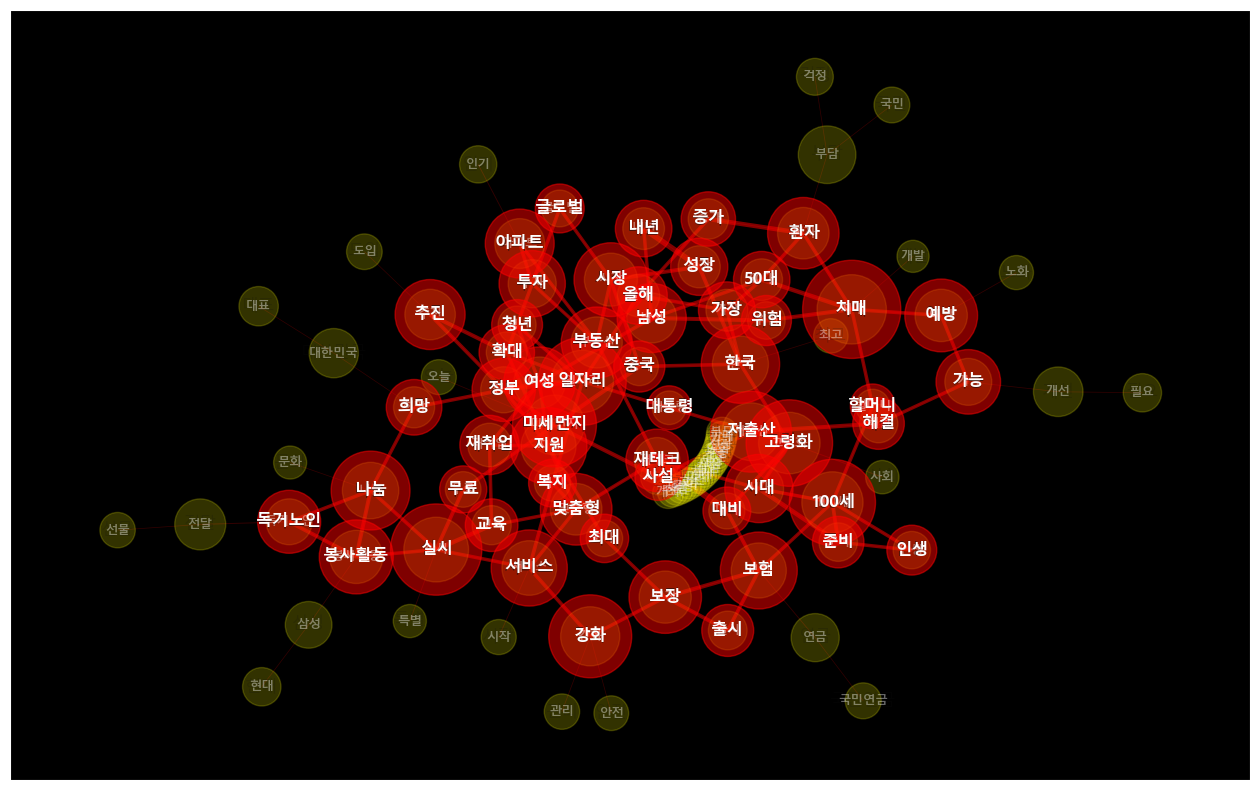

2018 ~ 2023


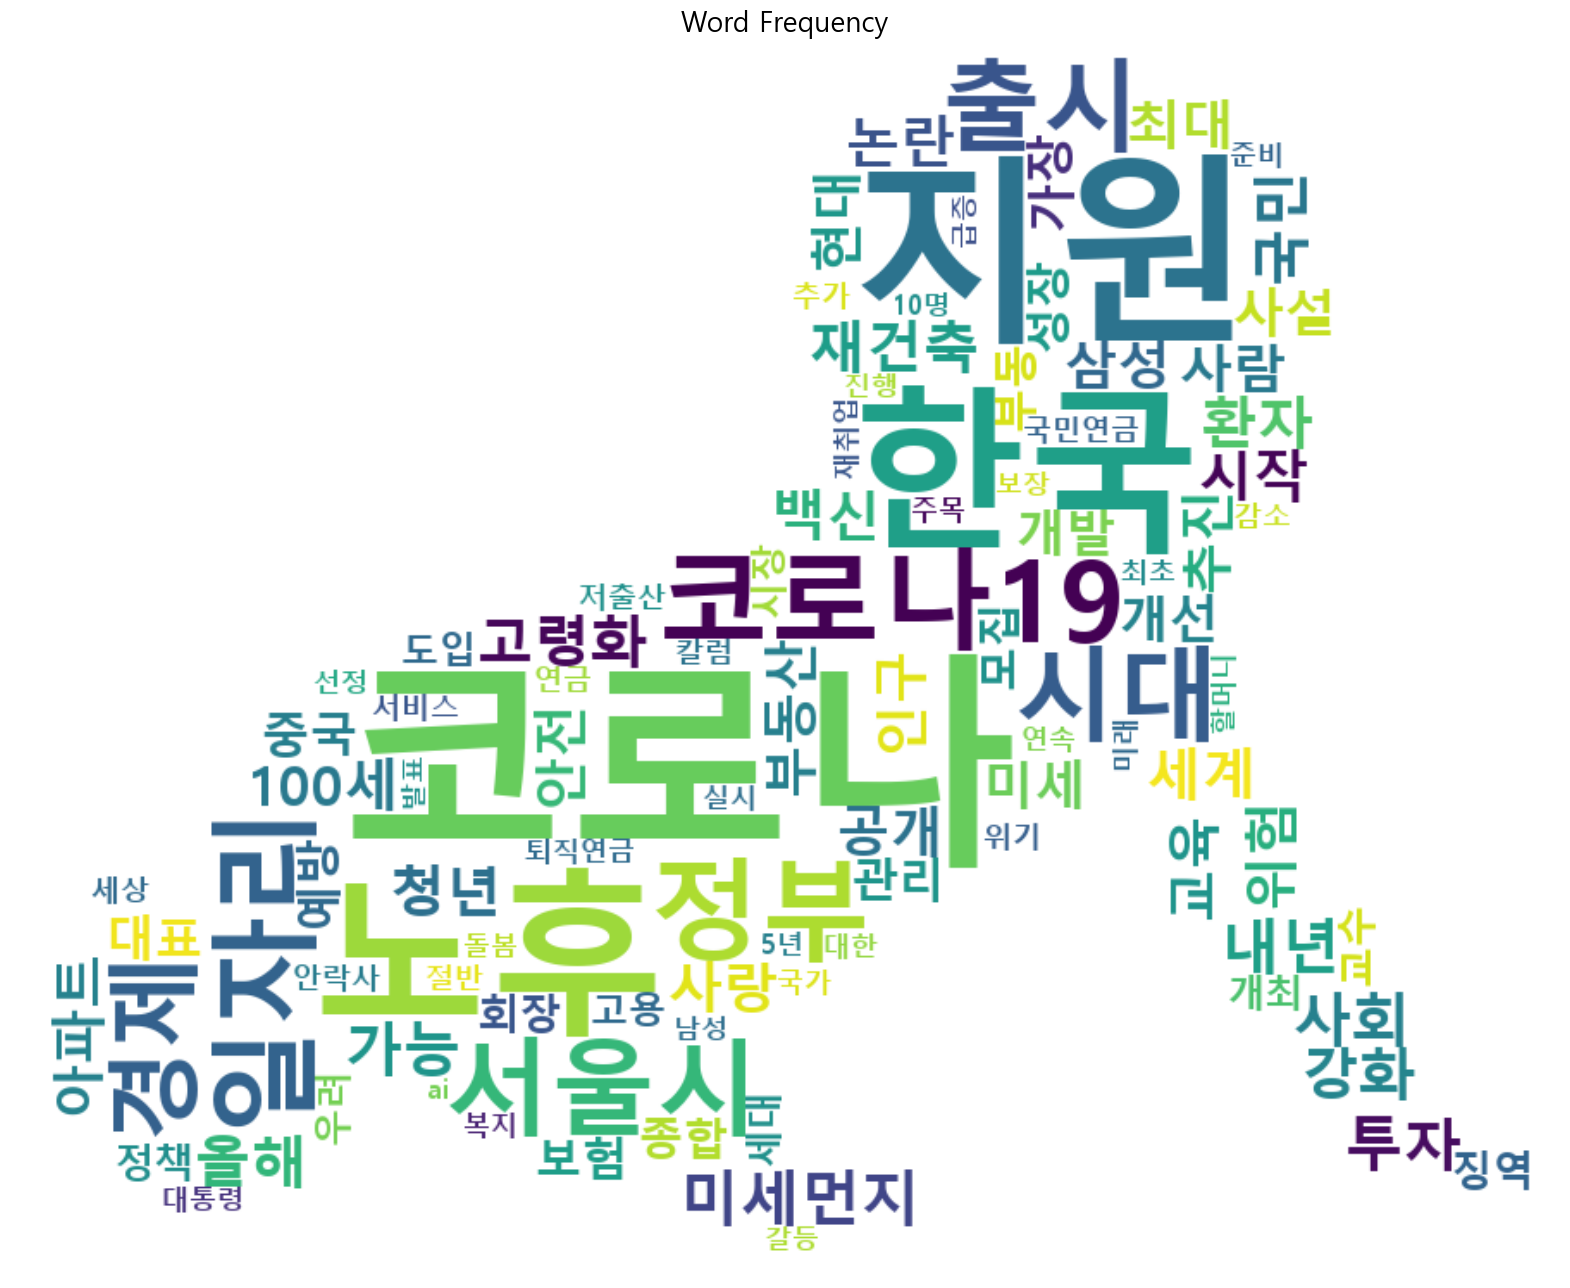

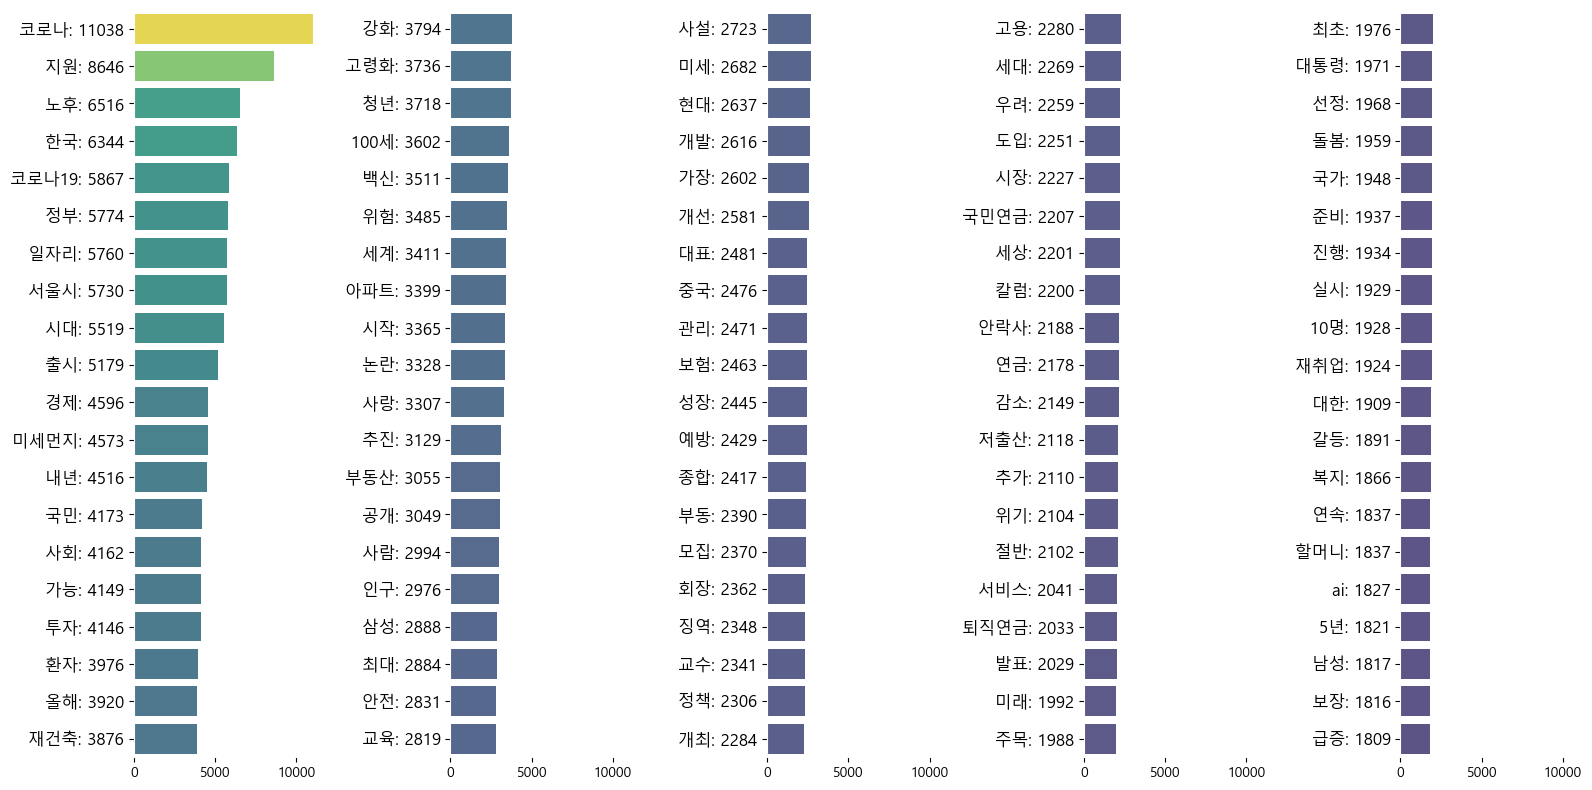

'Descriptive statistics of pairweight: '

count   mean    std     min     25%     50%    75%    max
correlation 9,702.0000 0.0006 0.0107 -0.0117 -0.0034 -0.0017 0.0013 0.3138

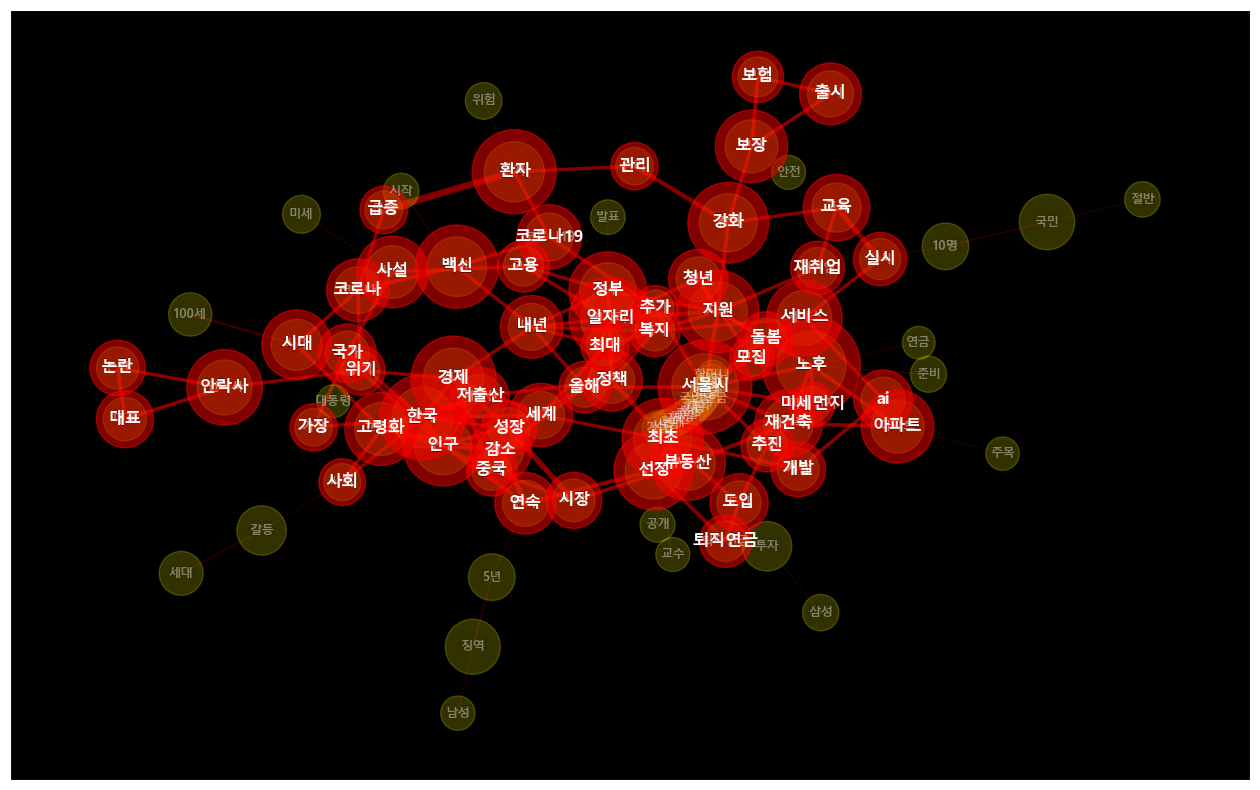

In [15]:
# 연도별 word freq 시각화
centrality_categ = pd.DataFrame()
for category in wf_era_soynlp[wf_era_soynlp.columns[0]].unique():
    print(category)
    wf_sub = wf_era_soynlp.groupby(wf_era_soynlp.columns[0]).get_group(category)
    wc_sub = wf_corr_soynlp[wf_corr_soynlp.category.isin([category])]
    
    plot_wordcloud(wf_sub.iloc[:,1:], mask_colorgen=False, max_words=100, mask_location=IMAGE_LOCATION, save_local=True, save_name='trend_era_wordcloud_'+'~'.join(category.split(' ~ '))+'.png')
    plot_bar_wordfreq(wf_sub.iloc[:,1:], figsize=(16,8), num_showkeyword=100, title='Ageism by Era', 
                      save_local=True, save_name='trend_era_bar_'+'~'.join(category.split(' ~ '))+'.png')
    plot_donut_wordfreq(wf_sub.iloc[:,1:], num_showkeyword=30, save_local=True, save_name='trend_era_donut_'+'~'.join(category.split(' ~ '))+'.html')
    _, centrality = plot_networkx(wf_sub, wc_sub.iloc[:,1:], 
                                  filter_criteria=0.02, plot=True, node_size='pagerank', save_local=True, save_name='trend_era_networkx_'+'~'.join(category.split(' ~ '))+'.png')
    ## 카테고리 추가
    centrality['category'] = str(category)
    centrality_categ = pd.concat([centrality_categ, centrality], axis=0, ignore_index=True)

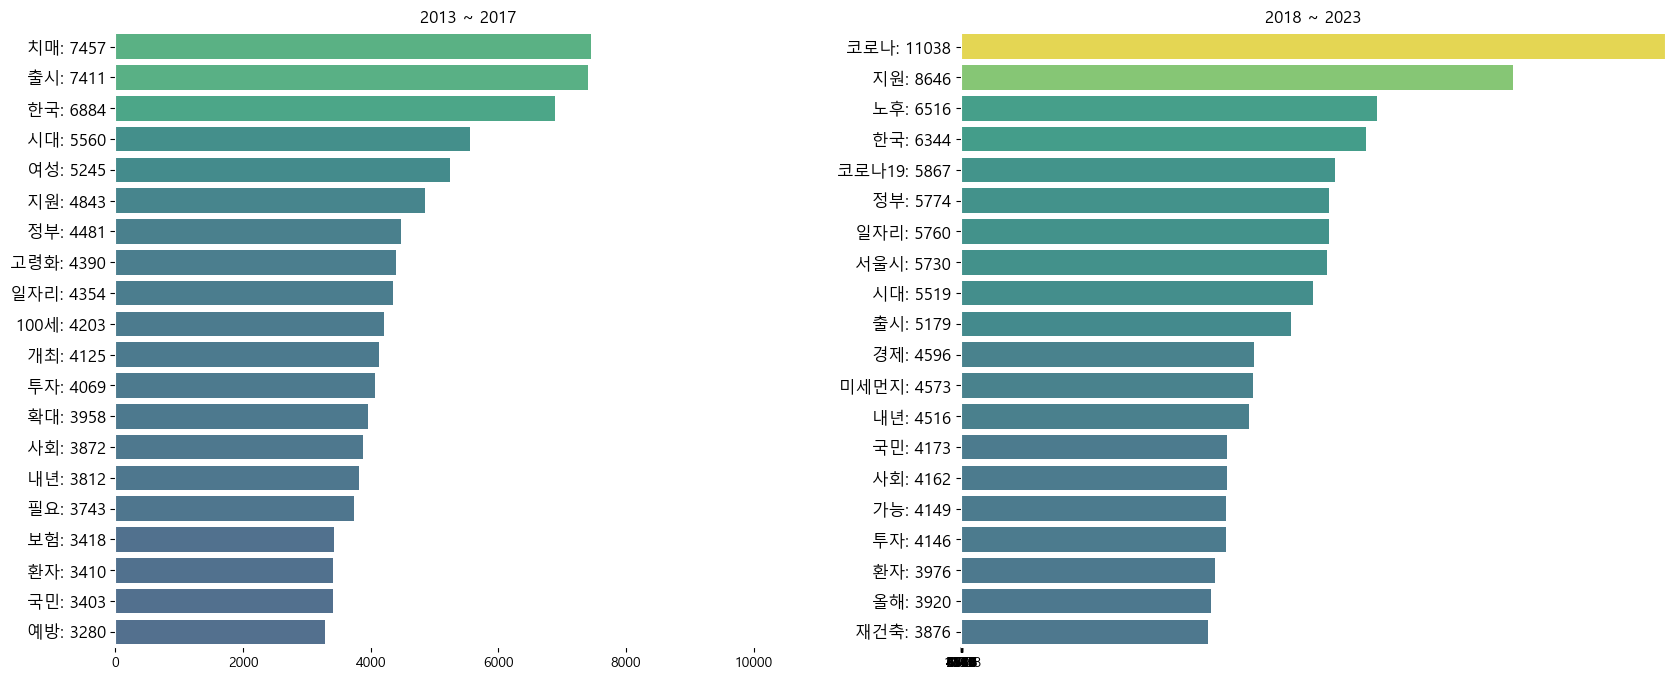

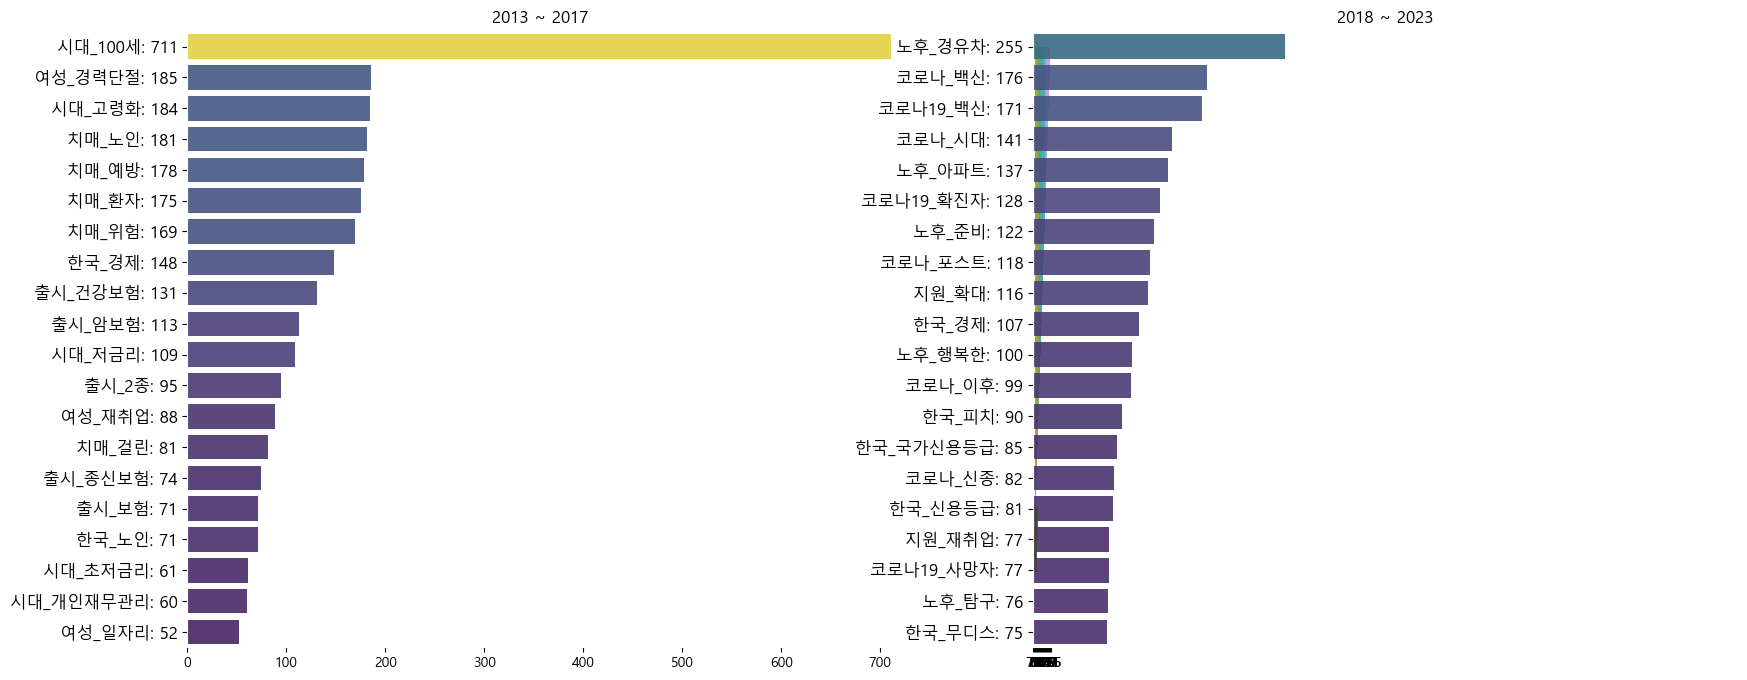

In [16]:
# word freq 비교 트랜드 시각화
plot_treemap_wordfreq(wf_era_soynlp, num_showkeyword=100, title='Ageism_Era', plot_studio=True, save_local=True, save_name='trend_era_compare_treemap_'+'~'.join(category.split(' ~ '))+'.html')
plot_sunburst_wordfreq(waf_era_soynlp, title='Ageism_Era', plot_studio=True, save_local=True, save_name='trend_era_compare_sunburst_'+'~'.join(category.split(' ~ '))+'.html')
plot_bar_wordfreq(wf_era_soynlp, figsize=(20,8), num_showkeyword=20, title='Ageism_Era', save_local=True, save_name='trend_era_compare_bar_byword_'+'~'.join(category.split(' ~ '))+'.png')
plot_bar_wordfreq(waf_era_soynlp, figsize=(20,8), num_showkeyword=20, title='Ageism_Era', save_local=True, save_name='trend_era_compare_bar_bywordadj_'+'~'.join(category.split(' ~ '))+'.png')

## 긍부정 트렌드: 연도별

In [12]:
df_plot = df_news_bk.groupby('일자_YearMonth')[['Positive', 'Negative']].sum()
plot_bar(df_plot, summation=True, title='Ageism Sentiment')

## 긍부정 트렌드: 연도 및 카테고리별

In [12]:
df_plot = df_news_bk.groupby(['Category', '일자_YearMonth'])[['Positive', 'Negative']].sum()
for categ in df_plot.index.get_level_values(0).unique():
    idx_sub = [idx for idx in df_plot.index if idx[0] == categ]
    df_sub = df_plot.loc[idx_sub,:].droplevel(0)
    plot_bar(df_sub, summation=True, title=categ)

## 긍부정 트렌드: 연도 및 키워드별

In [13]:
df_plot = df_news_bk.groupby(['Folder_Name', '일자_YearMonth'])[['Positive', 'Negative']].sum()
for categ in df_plot.index.get_level_values(0).unique():
    idx_sub = [idx for idx in df_plot.index if idx[0] == categ]
    df_sub = df_plot.loc[idx_sub,:].droplevel(0)
    plot_bar(df_sub, summation=True, title=categ)

## 긍부정 기사에 따른 키워드 트랜드 차이

In [11]:
# word freq 비교 트랜드 시각화
plot_treemap_wordfreq(wf_senti_soynlp, num_showkeyword=100, title='Ageism by Sentiment', plot_studio=True, save_local=True, save_name='trend_senti_compare_treemap.html')
plot_sunburst_wordfreq(waf_senti_soynlp, title='Ageism by Sentiment', plot_studio=True, save_local=True, save_name='trend_senti_compare_sunburst.html')

# 연구문제2

In [ ]:
topic_kwdinfo, model = modeling_BERTopic(df_news_bk['제목'], vectorizer_type='tfidf', max_topicnum=None, num_topicwords=10, max_features=1000)
model_time = model.topics_over_time(df_news_bk['제목'], timestamps=df_news_bk['일자'], datetime_format='%Y%m%d', nr_bins=20)
display(topic_kwdinfo, model.visualize_topics(), model.visualize_barchart(), model.visualize_topics_over_time(topics_over_time=model_time, top_n_topics=20))

In [16]:
topic_kw, doc_topic, vis_input = modeling_LDA(df_news_bk['제목'], max_topicnum=None, num_topicwords=10, plot_topicdoc=True)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(vis_input[0], vis_input[1], vis_input[2])
pyLDAvis.display(vis)

Estimating Optimal Topic Number...


 27%|████████████████████▉                                                          | 13/49 [31:10<1:26:19, 143.89s/it]


KeyboardInterrupt: 

## Testing

In [ ]:
# https://teddylee777.github.io/huggingface/bert-kor-text-classification/

In [ ]:
from transformers import pipeline, AutoTokenizer, BertTokenizer, BertTokenizerFast
from transformers import AutoModel, AutoModelForTokenClassification, TFBertModel, TFBertForSequenceClassification

TASK = 'text-classification'
MODEL_NAME = 'monologg/kobert' # 'bert-base-multilingual-cased'
SENTENCES = df_news['제목'].to_list()[:2]
SEQ_LEN = 32

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer(SENTENCES, max_length=SEQ_LEN, 
          padding='max_length', truncation=True, return_tensors='pt')

# model_sa = pipeline(task=TASK, model=MODEL_NAME)
# result = model_sa(df_news['제목'].to_list()[:100])
# for i, j in zip(df_news['제목'].to_list()[:100], result):
#     print(i,j)

In [ ]:
MODEL_NAME = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

X_train = preprocessing_sentence_to_BERTinput(df_news['제목'][:100], tokenizer=tokenizer)

def modeling_BERTsentiment(model_name, optimizer, seq_len=128):
    # 입력 변환
    tokens = tf.keras.layers.Input((seq_len,), dtype=tf.int32, name='input_ids')
    masks = tf.keras.layers.Input((seq_len,), dtype=tf.int32, name='input_masks')
    segments = tf.keras.layers.Input((seq_len,), dtype=tf.int32, name='input_segments')
    
    # 모델 로딩
    model = TFBertModel.from_pretrained(model_name)
    outputs = model([tokens, masks, segments])[1]
    
    # 모델 구성
    layer = tf.keras.layers.Dense(1, activation='sigmoid', 
                                  kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(outputs)
    model_sentiment = tf.keras.Model([tokens, masks, segments], layer)
    model_sentiment.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])
    
    return model_sentiment

In [ ]:
# https://towardsdatascience.com/chord-diagrams-of-protein-interaction-networks-in-python-9589affc8b91
    
import nxviz as nv
from nxviz import annotate, highlights
from nxviz.plots import despine, rescale, respine

def plot_nxviz(df_freq, df_pairweight, filter_criteria=None):
    pass

G, centrality_total = plot_networkx(FREQ_USING, df_word_corrpair, filter_criteria=None, plot=False)
ax = nv.circos(G, group_by="group_node", node_color_by="group_node")
annotate.circos_labels(G, group_by="group_node", radius=np.pi)
annotate.node_colormapping(G, color_by='group_node')
# annotate.node_labels(G, group_by="group_node", sort_by='score')
annotate.circos_group(G, group_by="group_node")